# My Youtube Video and Youtube Music Analytics


In [2]:
import pandas as pd
import numpy as np
import json
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
import seaborn as sns
from datetime import datetime
from bs4 import BeautifulSoup

### Import Search Data from HTMl File

The youtube search data html seems to contain alot of ads for some reason so i wrote some code to grab only the search data. The data i am interested in is the search Title, the time it was searched and the link.

In [5]:
# Read the HTML file
file_path = "data/youtube/search-history.html"
with open(file_path, 'r', encoding='utf-8') as file:
    html_content = file.read()

# Parse the HTML
soup = BeautifulSoup(html_content, 'html.parser')


data = []
for item in soup.find_all('div'): # Extract All The divs
    text = item.text
    text = text.strip()  # Strip any surrounding whitespace
    if text.startswith('Searched for'): # Find only the divs that have the Searched for text within them
        a = item.find('a')
        href = a.get('href')
        if 'search_query=' in href:
            data.append({
                'Search Query': a.text,
                'Time': item.decode_contents().split('<br/>')[1],
                'Link': href, 
            })

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

                                       Search Query  \
0                                       manhwa fest   
1                      How to beat Amatsu longsword   
2                                How to beat Amatsu   
3                      Best end game long sword mhr   
4     projects to build for your power BI portfolio   
...                                             ...   
7673           fire in the booth mandem on the wall   
7674                                murda seyi shay   
7675                                       ndani tv   
7676                  the life of a nigerian couple   
7677           nigerian couple marriage counselling   

                                Time  \
0      Sep 4, 2024, 12:03:09 AM AEST   
1     Aug 30, 2024, 11:46:22 PM AEST   
2     Aug 30, 2024, 11:43:55 PM AEST   
3      Aug 30, 2024, 1:07:48 AM AEST   
4      Aug 28, 2024, 2:51:42 PM AEST   
...                              ...   
7673    Dec 8, 2015, 1:43:34 AM AEST   
7674   Dec 8, 2015,

In [6]:
search_history_df = df
search_history_df

,Search Query,Time,Link
0,manhwa fest,"Sep 4, 2024, 12:03:09 AM AEST",https://www.youtube.com/results?search_query=m...
1,How to beat Amatsu longsword,"Aug 30, 2024, 11:46:22 PM AEST",https://www.youtube.com/results?search_query=H...
2,How to beat Amatsu,"Aug 30, 2024, 11:43:55 PM AEST",https://www.youtube.com/results?search_query=H...
3,Best end game long sword mhr,"Aug 30, 2024, 1:07:48 AM AEST",https://www.youtube.com/results?search_query=B...
4,projects to build for your power BI portfolio,"Aug 28, 2024, 2:51:42 PM AEST",https://www.youtube.com/results?search_query=p...
...,...,...,...
7673,fire in the booth mandem on the wall,"Dec 8, 2015, 1:43:34 AM AEST",https://www.youtube.com/results?search_query=f...
7674,murda seyi shay,"Dec 8, 2015, 12:55:34 AM AEST",https://www.youtube.com/results?search_query=m...
7675,ndani tv,"Dec 8, 2015, 12:27:10 AM AEST",https://www.youtube.com/results?search_query=n...
7676,the life of a nigerian couple,"Dec 7, 2015, 11:57:06 PM AEST",https://www.youtube.com/results?search_query=t...


### Convert Time to Datetime

In [8]:
# Assuming your DataFrame is named watch_history_df and has a 'Time' column
search_history_df['Time'] = pd.to_datetime(search_history_df['Time'])

# Verify the conversion
print(search_history_df['Time'].head())

/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_16379/594223733.py:2: FutureWarning: Parsing 'AEST' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  search_history_df['Time'] = pd.to_datetime(search_history_df['Time'])
/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_16379/594223733.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  search_history_df['Time'] = pd.to_datetime(search_history_df['Time'])


0   2024-09-04 00:03:09+10:00
1   2024-08-30 23:46:22+10:00
2   2024-08-30 23:43:55+10:00
3   2024-08-30 01:07:48+10:00
4   2024-08-28 14:51:42+10:00
Name: Time, dtype: datetime64[ns, UTC+10:00]


In [9]:
# Open the file and load the JSON data
with open('data/youtube/watch-history.json', encoding='utf-8') as file:
    data = json.load(file)

# Now `data` contains the JSON data as a Python dictionary or list
data[:3]

[{'header': 'YouTube',
  'title': 'Watched How to Download Your YouTube History! Download YouTube history!',
  'titleUrl': 'https://www.youtube.com/watch?v=zlzzO1e6dws',
  'subtitles': [{'name': 'Scoby Tech',
    'url': 'https://www.youtube.com/channel/UCRHZGz8g6b10rcvhcaq1M5A'}],
  'time': '2024-09-04T11:17:23.145Z',
  'products': ['YouTube'],
  'activityControls': ['YouTube watch history']},
 {'header': 'YouTube',
  'title': 'Watched @Wendigoon Confesses His Darkest Fears & What Videos Keep Him Up at Night | YouTube Watch History',
  'titleUrl': 'https://www.youtube.com/watch?v=sw6UGkFBIEs',
  'subtitles': [{'name': 'YouTube',
    'url': 'https://www.youtube.com/channel/UCBR8-60-B28hp2BmDPdntcQ'}],
  'time': '2024-09-04T11:17:04.455Z',
  'products': ['YouTube'],
  'activityControls': ['YouTube watch history']},
 {'header': 'YouTube',
  'title': 'Watched He Was Humiliated But Gained the SKILL to Steal TALENTS By Killing and Decided Get REVENGE - Manhwa',
  'titleUrl': 'https://www.you

In [10]:
watch_history_data = []
for item in data:
    if item.get('subtitles'):
        watch_history_data.append({
            'Title': item['title'].replace("Watched", "").strip(),
            'Time': item['time'],
            # 'Link': item['titleUrl'],
            'Channel Name': item['subtitles'][0]['name'],
            'Activity': item['activityControls'][0]
        })
    else:
        continue

# Convert the list of dictionaries to a DataFrame
watch_history_df = pd.DataFrame(watch_history_data)

In [11]:
watch_history_df

,Title,Time,Channel Name,Activity
0,How to Download Your YouTube History! Download...,2024-09-04T11:17:23.145Z,Scoby Tech,YouTube watch history
1,@Wendigoon Confesses His Darkest Fears & What ...,2024-09-04T11:17:04.455Z,YouTube,YouTube watch history
2,He Was Humiliated But Gained the SKILL to Stea...,2024-09-04T11:05:47.994Z,Mamoru Manhwa,YouTube watch history
3,[S1] This Noble Gets Reincarnated As The Stron...,2024-09-04T09:33:32.975Z,Manhwa Fest,YouTube watch history
4,Part 3 - I found a dog stuck under a huge log ...,2024-09-04T09:33:16.683Z,What In The World,YouTube watch history
...,...,...,...,...
34884,Drake Flirts With Vanessa Hudgens 😂,2023-05-23T18:47:11.357Z,Dripped Shorts,YouTube watch history
34885,The New York Times must fire this writer immed...,2023-05-23T18:46:36.275Z,HangTime,YouTube watch history
34886,LeSmart James is too smart! #shorts #lebronjames,2023-05-23T18:46:00.722Z,HangTime NBA,YouTube watch history
34887,How NLE Choppa Skyrocketed His Career…,2023-05-23T18:45:01.598Z,mario perez,YouTube watch history


### Convert Time to Datetime

In [13]:
# Convert the 'Time' column to datetime, handling mixed formats
watch_history_df['Time'] = pd.to_datetime(watch_history_df['Time'], errors='coerce')

# Verify the conversion
print(watch_history_df['Time'].head())

0   2024-09-04 11:17:23.145000+00:00
1   2024-09-04 11:17:04.455000+00:00
2   2024-09-04 11:05:47.994000+00:00
3   2024-09-04 09:33:32.975000+00:00
4   2024-09-04 09:33:16.683000+00:00
Name: Time, dtype: datetime64[ns, UTC]


### Top Channels 

/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_16379/2794654019.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_channels.values, y=top_channels.index, palette='viridis')


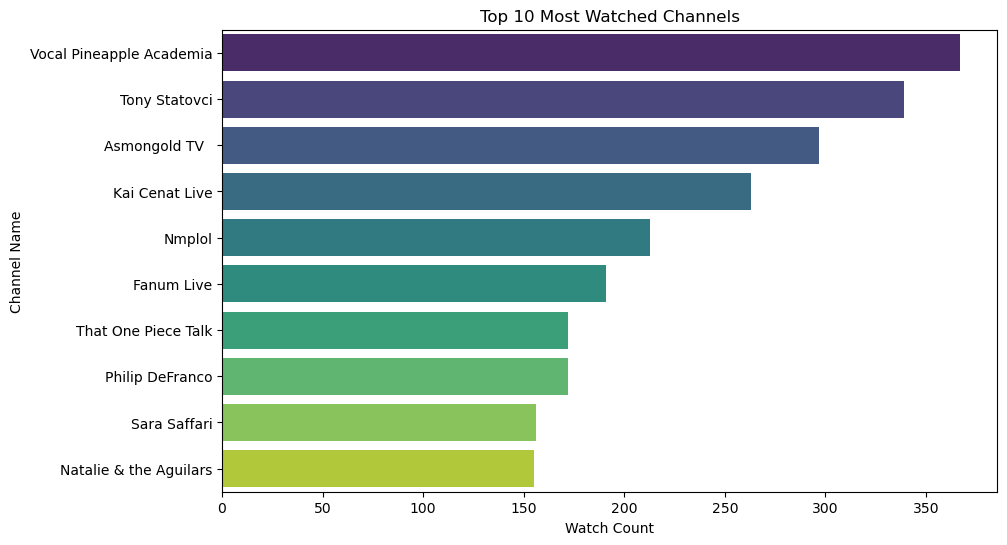

In [63]:
# Step 1: Count the occurrences of each channel
channel_counts = watch_history_df['Channel Name'].value_counts()

# Step 2: Sort channels by frequency (top 10 most watched channels)
top_channels = channel_counts.head(10)  # Get top 10 channels

# Step 3: Visualize the top channels using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_channels.values, y=top_channels.index, palette='viridis')

# Customize the plot
plt.title('Top 10 Most Watched Channels')
plt.xlabel('Watch Count')
plt.ylabel('Channel Name')

plt.show()

### Viewing and Searching Time Patterns

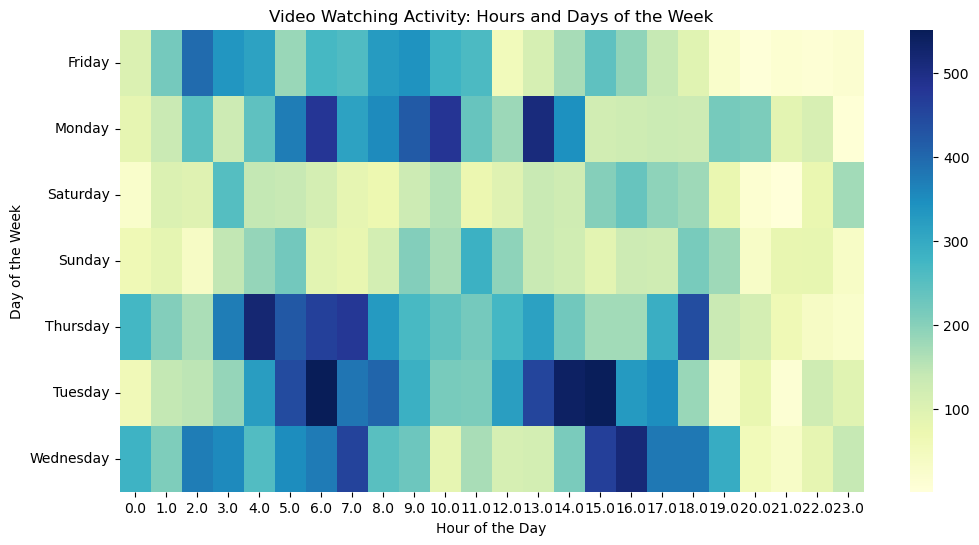

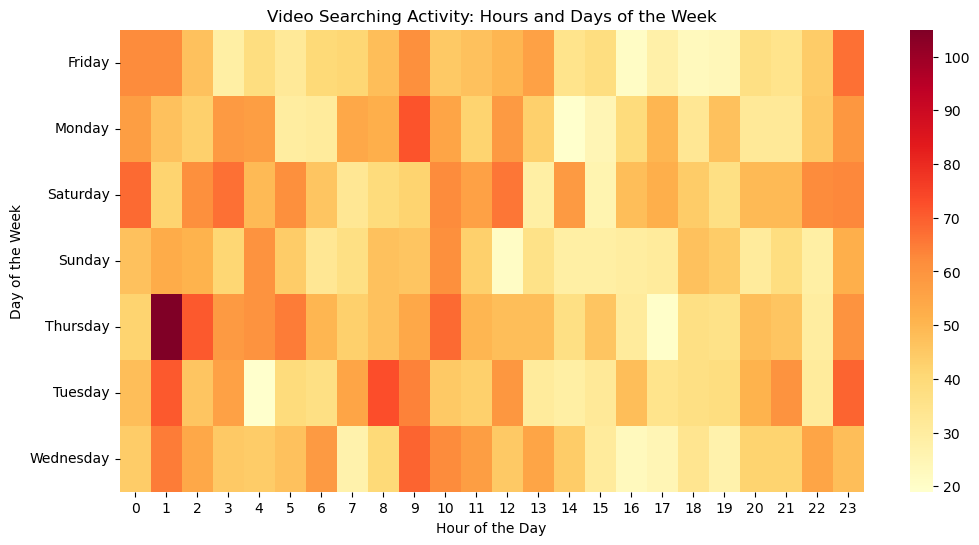

In [53]:
# Assuming 'watch_history_df' and 'search_history_df' are your DataFrames

# Step 1: Convert 'Time' columns to datetime if not already done
watch_history_df['Time'] = pd.to_datetime(watch_history_df['Time'])
search_history_df['Time'] = pd.to_datetime(search_history_df['Time'])

# Step 2: Extract the hour and day of the week
watch_history_df['Hour'] = watch_history_df['Time'].dt.hour
watch_history_df['Day of Week'] = watch_history_df['Time'].dt.day_name()

search_history_df['Hour'] = search_history_df['Time'].dt.hour
search_history_df['Day of Week'] = search_history_df['Time'].dt.day_name()

# Step 3: Plot the distribution of activity over hours and days

# Heatmap for Watching Activity
watch_heatmap_data = watch_history_df.groupby(['Day of Week', 'Hour']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(watch_heatmap_data, cmap='YlGnBu', annot=False, cbar=True)
plt.title('Video Watching Activity: Hours and Days of the Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.show()

# Heatmap for Searching Activity
search_heatmap_data = search_history_df.groupby(['Day of Week', 'Hour']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(search_heatmap_data, cmap='YlOrRd', annot=False, cbar=True)
plt.title('Video Searching Activity: Hours and Days of the Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.show()

### Search Keyword Map

In [43]:
# Assuming 'search_df' has a 'Title' column for search queries
stop_words = set(stopwords.words('english'))

# Tokenize the search titles
search_words = search_history_df['Search Query'].str.lower().str.split().apply(lambda x: [word for word in x if word not in stop_words])

# Flatten the list and count the word frequency
all_search_words = [word for sublist in search_words for word in sublist]
word_freq = Counter(all_search_words).most_common(20)

print(word_freq)  # Top 20 search keywords

[('effects', 280), ('play', 174), ('video', 168), ('ring', 165), ('elden', 164), ('effect', 158), ('best', 157), ('react', 153), ('make', 145), ('js', 132), ('get', 131), ('tutorial', 126), ('music', 113), ('piano', 106), ('photoshop', 96), ('animation', 88), ('wordpress', 86), ('text', 68), ('hillsong', 65), ('pro', 65)]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samueladeyemi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


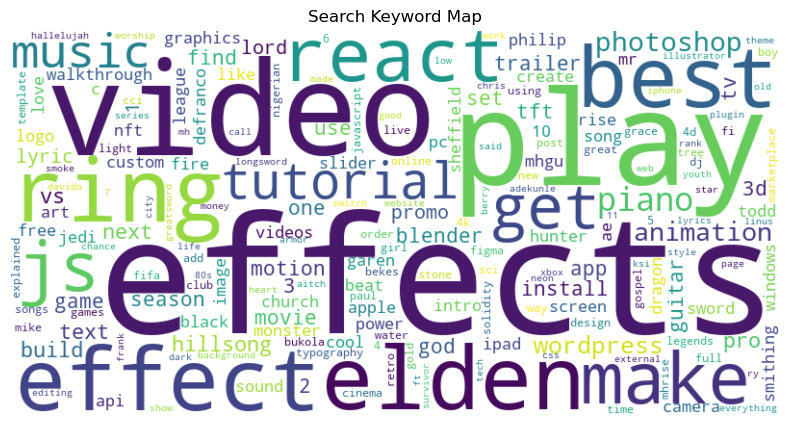

In [59]:
# Download stopwords if not already done
nltk.download('stopwords')

# Step 1: Tokenize the search queries
search_history_df['Search Query'] = search_history_df['Search Query'].astype(str)  # Convert to string if needed
search_terms = ' '.join(search_history_df['Search Query']).lower()  # Combine all search terms into a single string

# Step 2: Remove stopwords and punctuation
stop_words = set(stopwords.words('english'))
tokens = search_terms.split()
tokens_cleaned = [word for word in tokens if word not in stop_words and word not in string.punctuation]

# Step 3: Count the frequency of each word
word_freq = Counter(tokens_cleaned)

# Step 4: Visualize the keyword map using a Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axes
plt.title('Search Keyword Map')
plt.show()

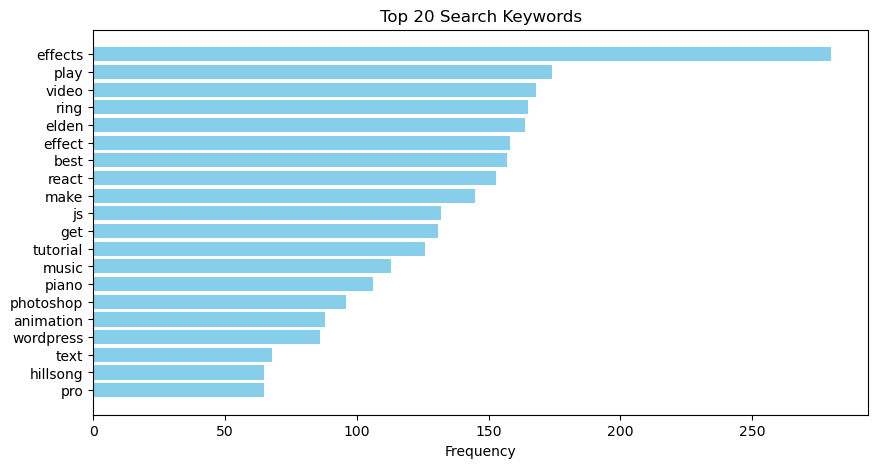

In [61]:
# Step 4: Visualize the top 20 words using a bar plot
top_20_words = word_freq.most_common(20)
words, counts = zip(*top_20_words)

plt.figure(figsize=(10, 5))
plt.barh(words, counts, color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 20 Search Keywords')
plt.gca().invert_yaxis()  # Invert y-axis to show the most frequent word at the top
plt.show()

### Channel Growth

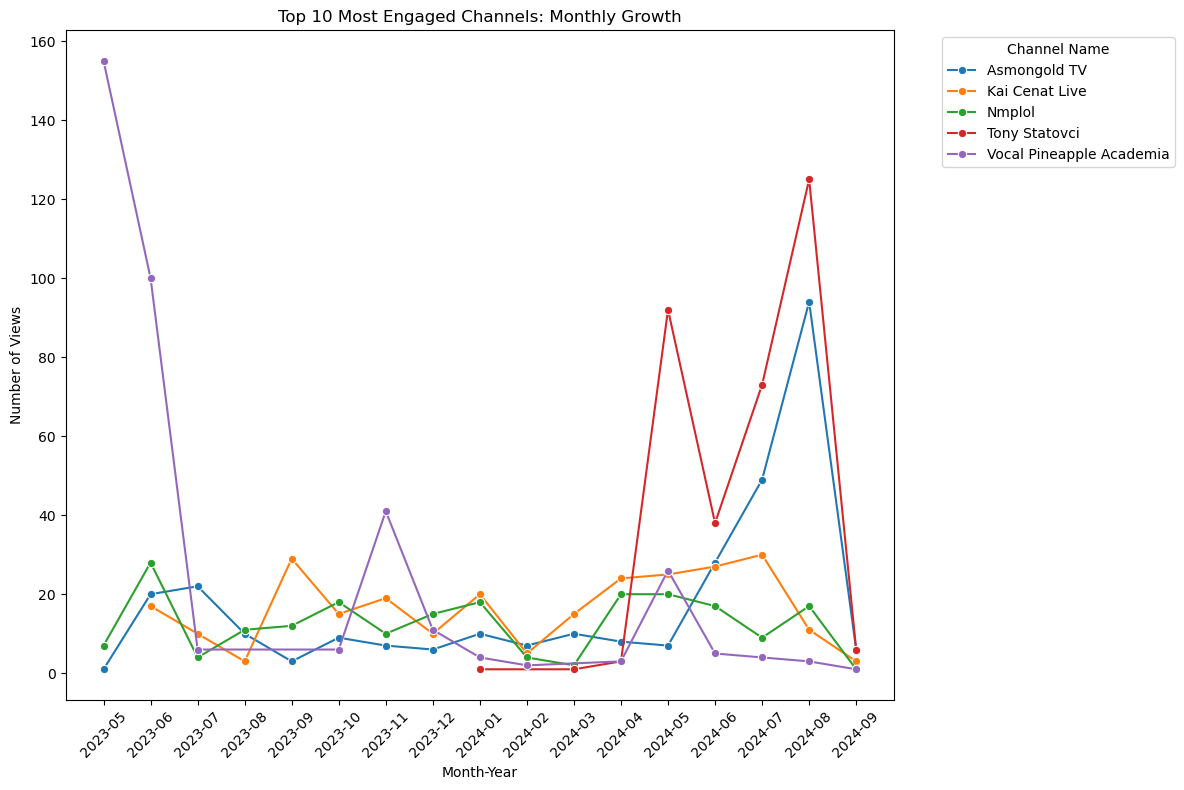

In [51]:
# Convert 'Time' column to datetime if not done already
watch_history_df['Time'] = pd.to_datetime(watch_history_df['Time'])

# Extract Year-Month for grouping
watch_history_df['Year-Month'] = watch_history_df['Time'].dt.to_period('M').astype(str)

# Group by 'Channel Name' and 'Year-Month', and count views
channel_growth = watch_history_df.groupby(['Channel Name', 'Year-Month']).size().reset_index(name='Watched Count')

# Convert 'Watched Count' to numeric (though it should already be numeric, this ensures it's correct)
channel_growth['Watched Count'] = pd.to_numeric(channel_growth['Watched Count'])

# Get top 10 most engaged channels
top_channels = watch_history_df['Channel Name'].value_counts().head(5).index
top_channel_growth = channel_growth[channel_growth['Channel Name'].isin(top_channels)]

# Plot the data
plt.figure(figsize=(12, 8))
sns.lineplot(data=top_channel_growth, x='Year-Month', y='Watched Count', hue='Channel Name', marker='o')

# Customize plot
plt.title('Top 10 Most Engaged Channels: Monthly Growth')
plt.xlabel('Month-Year')
plt.ylabel('Number of Views')
plt.xticks(rotation=45)
plt.legend(title='Channel Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()